In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

import pdb

images-size: torch.Size([32, 3, 32, 32])
out-size: torch.Size([3, 138, 274])


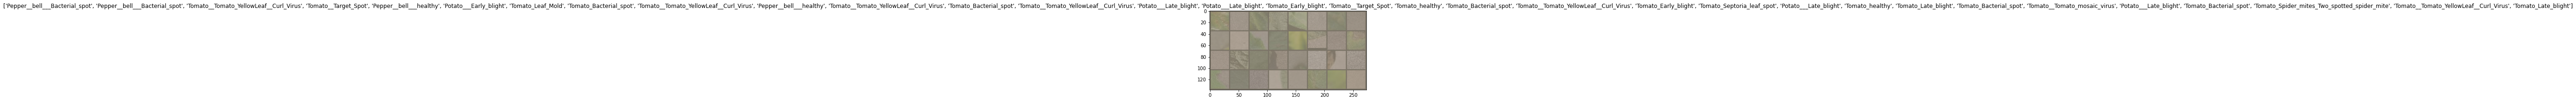

In [12]:
batch_size = 32
learning_rate = 1e-3

train_transform = transforms.Compose(
[
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

valid_transform = transforms.Compose(
[
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='PlantVillage_Training_Set', transform=train_transform)
#test_dataset = datasets.ImageFolder(root='test', transform=transform)
#test_dataset = datasets.ImageFolder(root='use_test_plantvillage_model', transform=valid_transform)
test_dataset = datasets.ImageFolder(root='PlantVillage_Testing_Set', transform=train_transform)
valid_dataset = datasets.ImageFolder(root='PlantVillage_Validation_Set', transform=train_transform)

#train_dataset,valid_dataset = torch.utils.data.dataset.random_split(tr_dataset, [round(0.9*len(tr_dataset)), round(0.1*len(tr_dataset))])

#pdb.set_trace()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(test_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[test_dataset.classes[x] for x in labels])

In [7]:
net = models.resnet18(pretrained=False)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 15)
net.fc = net.fc.cuda() if device else net.fc

In [9]:
device
net.fc

Linear(in_features=512, out_features=15, bias=True)

In [17]:
n_epochs = 400
print_every = 10
valid_loss_min = np.Inf
#val_loss = []
#val_acc = []
#train_loss = []
#train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (validation_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(validation_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/400], Step [0/439], Loss: 1.1631
Epoch [1/400], Step [20/439], Loss: 1.1206
Epoch [1/400], Step [40/439], Loss: 1.5420
Epoch [1/400], Step [60/439], Loss: 1.4577
Epoch [1/400], Step [80/439], Loss: 1.5894
Epoch [1/400], Step [100/439], Loss: 1.2954
Epoch [1/400], Step [120/439], Loss: 1.3931
Epoch [1/400], Step [140/439], Loss: 1.2980
Epoch [1/400], Step [160/439], Loss: 1.1746
Epoch [1/400], Step [180/439], Loss: 1.3409
Epoch [1/400], Step [200/439], Loss: 1.4937
Epoch [1/400], Step [220/439], Loss: 1.4144
Epoch [1/400], Step [240/439], Loss: 1.4132
Epoch [1/400], Step [260/439], Loss: 1.2441
Epoch [1/400], Step [280/439], Loss: 1.6853
Epoch [1/400], Step [300/439], Loss: 1.1191
Epoch [1/400], Step [320/439], Loss: 1.3907
Epoch [1/400], Step [340/439], Loss: 1.6610
Epoch [1/400], Step [360/439], Loss: 1.3553
Epoch [1/400], Step [380/439], Loss: 1.7937
Epoch [1/400], Step [400/439], Loss: 1.3232
Epoch [1/400], Step [420/439], Loss: 1.5848

train-loss: 1.5737, train-ac

KeyboardInterrupt: 

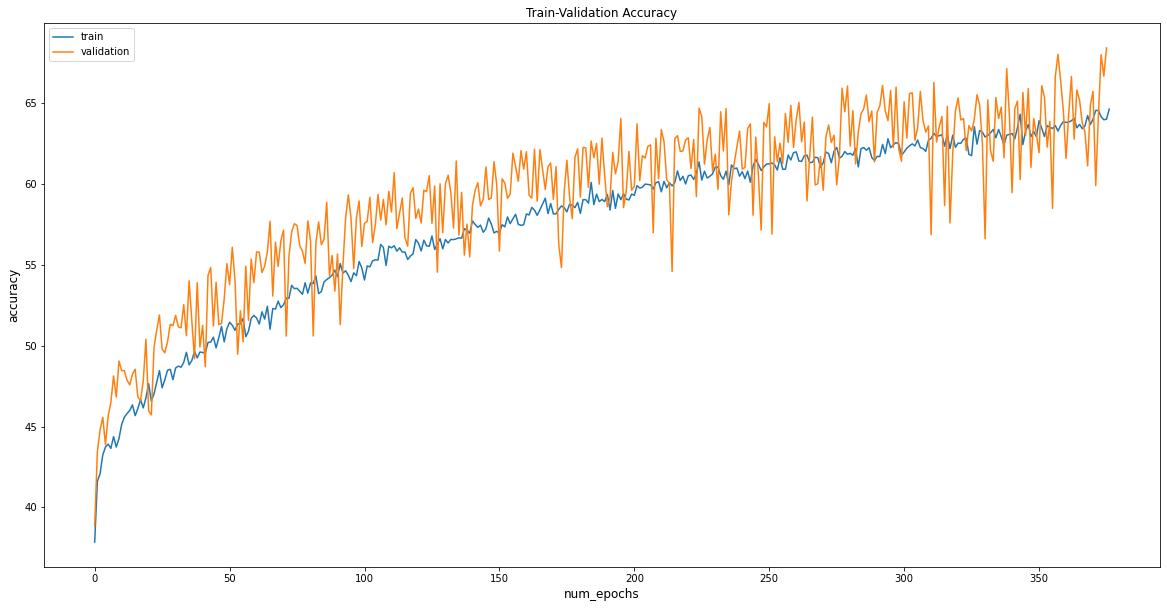

In [18]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [3]:
# Run if trained model available
net = models.resnet18(pretrained=False)
net = net.cuda() if device else net

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 15)
net.fc = net.fc.cuda() if device else net.fc

net.load_state_dict(torch.load('resnet.pt'))

<All keys matched successfully>

In [ ]:
from bs4 import BeautifulSoup
classes = set()
for i in range(2330):
    file = 'testing_leaf_type/annotations/plantdoc' + str(i) + '.xml'
    with open(file) as f:
        data = f.read()
        xml_data = BeautifulSoup(data, 'xml')
        objects = xml_data.find_all('name')
        for obj in objects:
            classes.add(obj)

In [27]:
def visualize_model(net, num_images=2076):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        #pdb.set_trace()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            #ax = plt.subplot(2, num_images//2, images_so_far)
            #ax.axis('off')
            #pdb.set_trace()
            #ax.set_title('predicted: {}'.format(train_dataset.classes[preds[j]]) + '    actual: {}'.format(test_dataset.classes[labels[j]]))
            #imshow(inputs[j])
            
            if images_so_far == num_images:
                print(sum((preds == labels.cpu().numpy())/len(preds)))
                return 
            
plt.ion()
visualize_model(net)
plt.ioff()

0.607142857142857


<Figure size 1080x720 with 0 Axes>

In [6]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

params

11184207

In [25]:
len(test_dataset)

2076